In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import torch

from concepts import concept_instances
from sk_probing import train_probe
from utils import load_game_data, load_q_network_device

In [3]:
game_data = load_game_data()

max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5
layer = '5'

actions = ['Noop', 'Fire', 'Right', 'Left']
q_network, device = load_q_network_device()
q_network.to('cpu')

In [4]:
concept_mean_max_gradient = {} # does adding a concept improve max(q value)?
concept_action_mean_gradient = {a:[] for a in actions} # does adding a concept improve mean(q value)?
concept_max_q_improvement = {} # does concept improve max(q value)?
concept_action_improvement = {a:[] for a in actions} # how often does concept improve action?
concept_action_max_gradient = {a:[] for a in actions} # how often did this action have the highest gradient?
concept_cavs = {} # save probe for each concept

In [5]:
# find layer as idx to skip to this part of the network
for idx, (name, l) in enumerate(q_network.network.named_children()):
    if name == layer:
        break

In [6]:
concept_names = []
for concept in concept_instances.values():
    concept_names.append(concept.name)
    concept.prepare_data(game_data)
    probe, score = train_probe(q_network, concept, layer, max_iter, k_fold, num_reg)
    print(f'{concept.name}: {score}')
    # get q values and test activations
    q_values, acts_dict = q_network(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]

    # extract cav from probe and reshape
    if concept.binary:
        cav = probe.coef_[0]
    else:
        cav = probe.coef_
    cav = torch.tensor(cav, dtype=torch.float32)
    concept_cavs[concept.name] = cav
    acts.requires_grad_(True)

    q_values = q_network.network[idx + 1:](acts)

    # Flatten the activations
    acts_flat = acts.view(acts.shape[0], -1)
    cav = cav / torch.norm(cav)
    cav_norm = cav / torch.norm(cav)

    # Initialize tensor to store results
    directional_derivatives = torch.zeros_like(q_values)

    # Compute directional derivatives
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        # Calculate directional derivative
        grads_flat = acts.grad.view(acts.shape[0], -1)
        directional_derivatives[:, j] = torch.mv(grads_flat, cav_norm)
    
        acts.grad.zero_()

    # calculate mean max (as in the best action) directional derivative
    concept_mean_max_gradient[concept.name] = torch.mean(torch.max(directional_derivatives, dim=1)[0]).item()

    mean_action_derivatives = torch.mean(directional_derivatives, dim=0).tolist()
    # calculate mean directional derivative for each concept
    for i, mdd in enumerate(mean_action_derivatives):
        concept_action_mean_gradient[actions[i]].append(mdd)

    # count how often max derivative is positive
    concept_max_q_improvement[concept.name] = torch.sum(torch.max(directional_derivatives, dim=1)[0] > 0).item() / directional_derivatives.shape[0]
    # count how often each action has a positive derivative
    action_improvement_counter = {i: torch.sum(directional_derivatives[:, i] > 0).item() / directional_derivatives.shape[0] for i in range(len(actions))}
    for i, action in enumerate(actions):
        action_name = actions[i]
        concept_action_improvement[action_name].append(action_improvement_counter[i])

    # count which action has the highest derivative
    max_action = torch.argmax(directional_derivatives, dim=1)
    most_improvement_counter = {i: sum(max_action == i) / directional_derivatives.shape[0] for i in range(len(actions))}
    for i, action in enumerate(actions):
        action_name = actions[i]
        concept_action_max_gradient[action_name].append(most_improvement_counter[i].item())


ball y: 0.5409021691218023
ball x: 0.8871338370567232
ball low (b): 0.9877750611246945
ball collision (b): 0.777456647398844
ball going right (b): 0.7694117647058825
ball going left (b): 0.7905882352941176
ball going up (b): 0.9095477386934674
ball going down (b): 0.9120603015075377
ball speed: 0.42099216073896073
paddle x: 0.9785209610017889
ball left for paddle (b): 0.7923497267759563
ball right for paddle (b): 0.7790697674418605
ball above paddle (b): 0.6777251184834123
ball paddle distance: 0.7251688485246178
lives: 0.9753926868253076
last life (b): 1.0
losing life (b): 0.989010989010989
random (b): -0.02708803611738153
brick hit (b): 0.9075630252100841
bricks hit: 0.9921979738774561


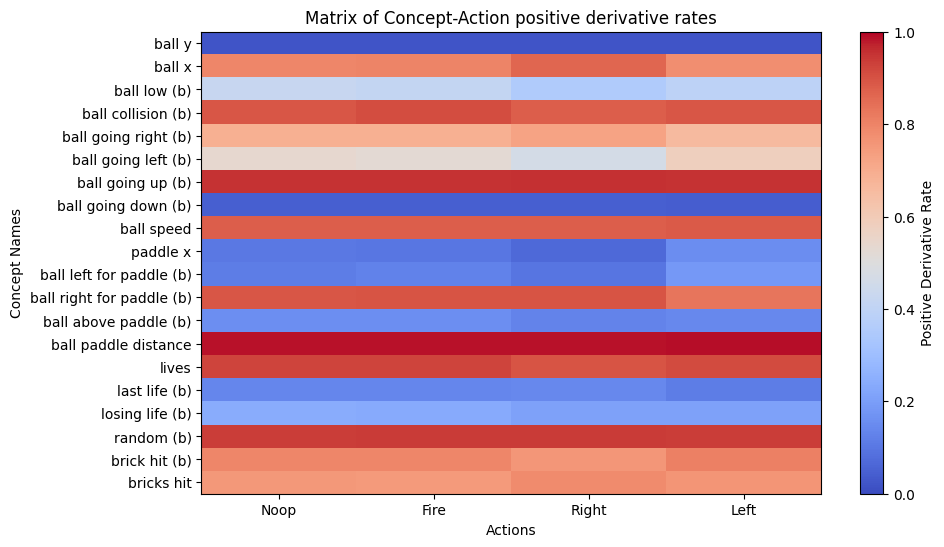

In [7]:
matrix = np.array(list(concept_action_improvement.values())).T
plt.figure(figsize=(10, 6))
plt.imshow(matrix, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Positive Derivative Rate')
plt.xticks(ticks=range(len(concept_action_mean_gradient)), labels=concept_action_mean_gradient.keys())
plt.yticks(ticks=range(len(concept_names)), labels=concept_names)
plt.title('Matrix of Concept-Action positive derivative rates')
plt.xlabel('Actions')
plt.ylabel('Concept Names')
plt.savefig('../figures/tcav/concept-action-positive-matrix.png')
plt.show()

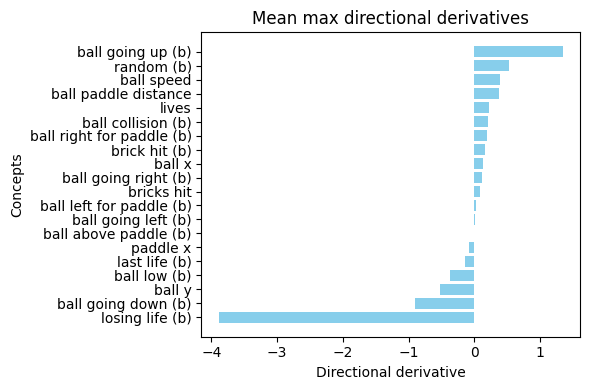

In [8]:
sorted_data = sorted(concept_mean_max_gradient.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Directional derivative')
plt.ylabel('Concepts')
plt.title('Mean max directional derivatives')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../figures/tcav/mean-max-directional-derivatives.png')
plt.show()

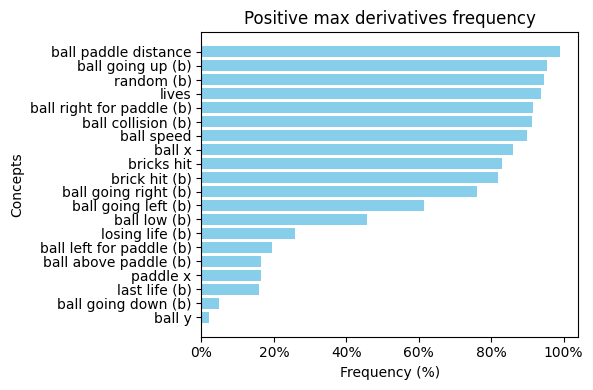

In [9]:
sorted_data = sorted(concept_max_q_improvement.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] * 100 for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Frequency (%)')
plt.ylabel('Concepts')
plt.title('Positive max derivatives frequency')
plt.gca().invert_yaxis()  # To display the largest values at the top
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.gca().xaxis.set_ticks(range(0, 101, 20))
plt.tight_layout()
plt.savefig('../figures/tcav/positive-max-derivative-frequency.png')
plt.show()

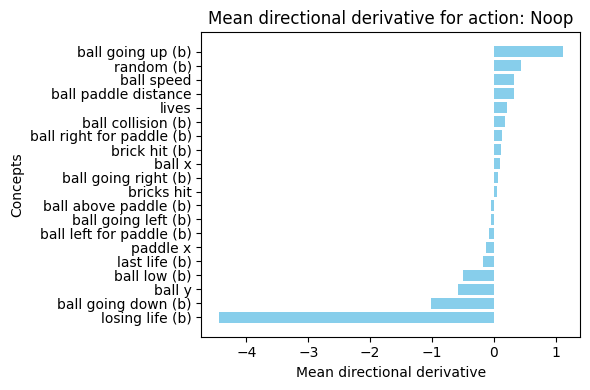

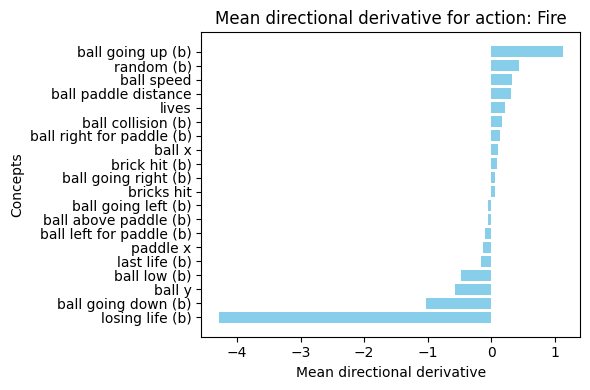

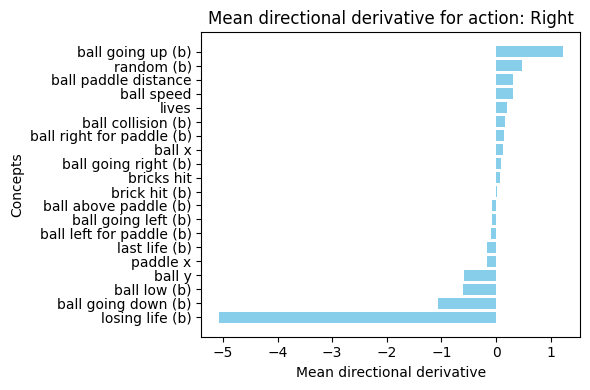

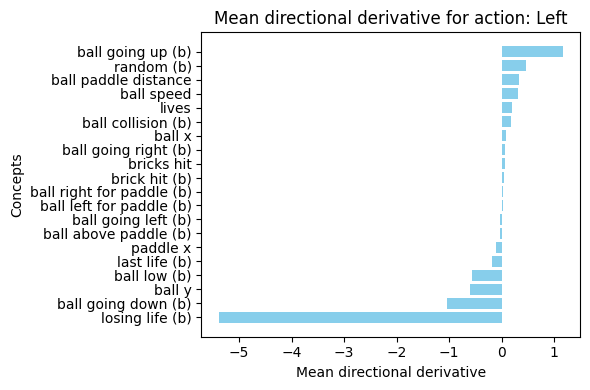

In [10]:
for action_name, values in concept_action_mean_gradient.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i] for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Mean directional derivative')
    plt.ylabel('Concepts')
    plt.title(f'Mean directional derivative for action: {action_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

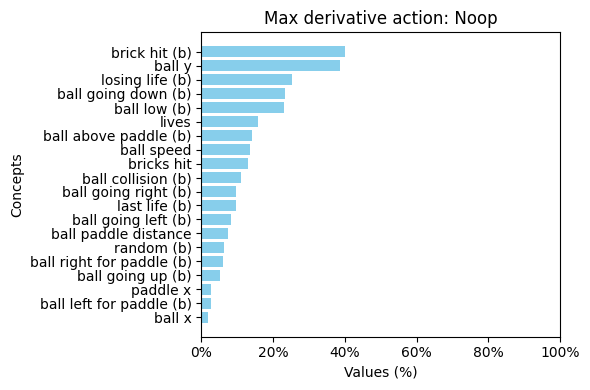

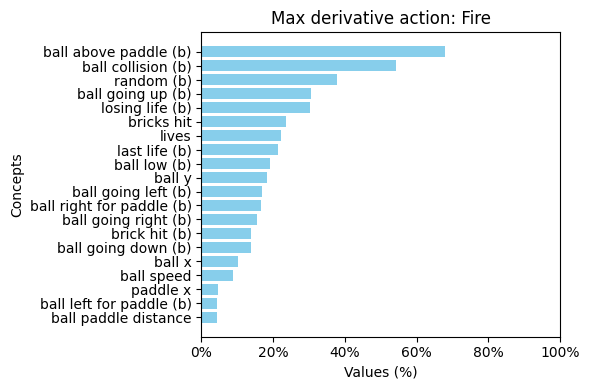

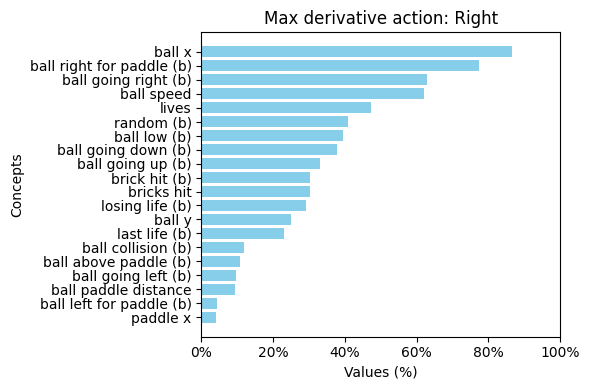

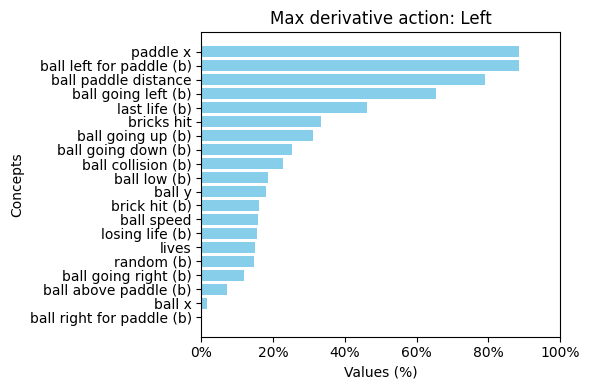

In [11]:
for action_name, values in concept_action_max_gradient.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i]*100 for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Values (%)')
    plt.ylabel('Concepts')
    plt.title(f'Max derivative action: {action_name}')
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    plt.gca().xaxis.set_ticks(range(0, 101, 20))
    plt.tight_layout()
    plt.savefig(f'../figures/tcav/max-derivative-action-{action_name}.png')
    plt.show()

### this but with % improvement

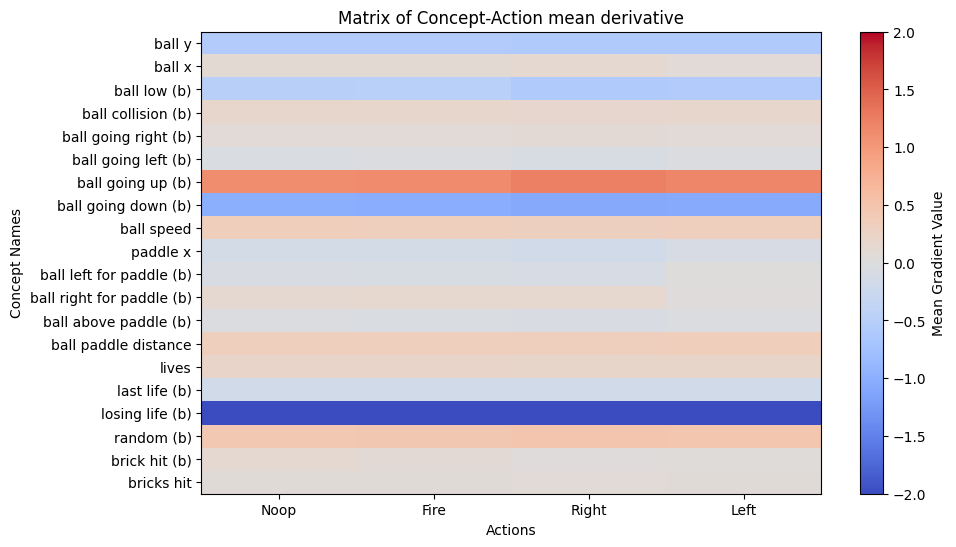

In [12]:
matrix = np.array(list(concept_action_mean_gradient.values()))

# Transposing the matrix to get actions as columns and concepts as rows
matrix = matrix.T

# Plotting the matrix
plt.figure(figsize=(10, 6))
plt.imshow(matrix, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
plt.colorbar(label='Mean Gradient Value')
plt.xticks(ticks=range(len(concept_action_mean_gradient)), labels=concept_action_mean_gradient.keys())
plt.yticks(ticks=range(len(concept_names)), labels=concept_names)
plt.title('Matrix of Concept-Action mean derivative')
plt.xlabel('Actions')
plt.ylabel('Concept Names')
plt.savefig('../figures/tcav/concept-action-mean-matrix.png')
plt.show()